In [1]:
import os
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
import h5py
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (Conv2D, BatchNormalization, Activation, UpSampling2D, 
                                     AveragePooling2D, Conv2DTranspose, Concatenate, Input)
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K

In [2]:
with h5py.File('/kaggle/input/landslide4sense/TrainData/img/image_1.h5', 'r') as hf:
    print(hf.keys())

<KeysViewHDF5 ['img']>


In [3]:
with h5py.File('/kaggle/input/landslide4sense/TrainData/mask/mask_10.h5', 'r') as hf1:
    print(hf1.keys())

<KeysViewHDF5 ['mask']>


Available keys in the HDF5 file: ['img']
Input data shape: (128, 128, 14)


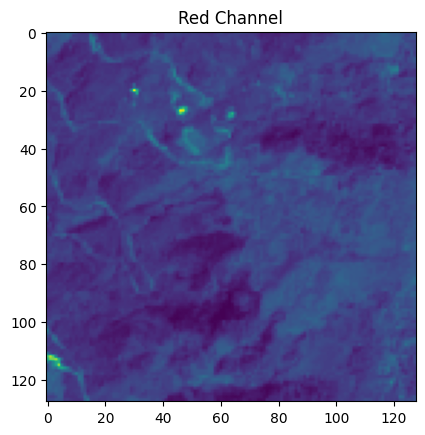

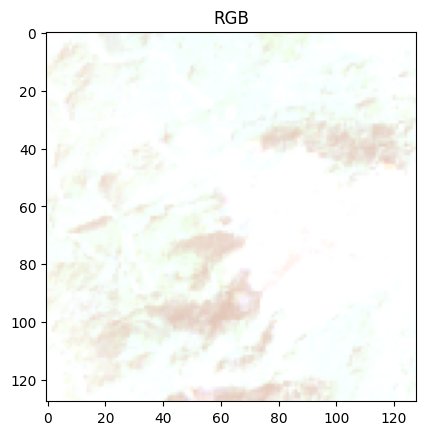

data_ndvi shape: (128, 128) f_data shape: (1, 128, 128, 3)


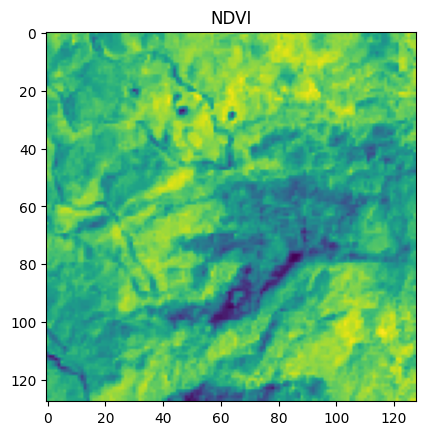

In [7]:
path_single = r'/kaggle/input/landslide4sense/TrainData/img/image_8.h5'
path_single_mask = r'/kaggle/input/landslide4sense/TrainData/mask/mask_8.h5'

f_data = np.zeros((1, 128, 128, 3))

# Open the HDF5 file
with h5py.File(path_single, 'r') as hdf:
    # Print keys in the HDF5 file
    ls = list(hdf.keys())
    print("Available keys in the HDF5 file:", ls)
    
    # Check if 'img' key exists
    if 'img' not in ls:
        raise KeyError("'img' key not found in HDF5 file")
    
    # Load the image data
    data = np.array(hdf.get('img'))
    print("Input data shape:", data.shape)
    
    # Check the shape to avoid indexing errors
    if data.shape[2] < 14:
        raise ValueError("The data has fewer than 14 channels. Shape:", data.shape)

    # Display the red channel of an image 
    plt.imshow(data[:, :, 3])  # Red channel 
    plt.title("Red Channel")
    plt.show()

    # RGB
    plt.imshow(data[:, :, 1:4])   
    plt.title("RGB")
    plt.show()

    # Extract specific bands for NDVI calculation
    data_red = data[:, :, 3]
    data_green = data[:, :, 2]
    data_blue = data[:, :, 1]
    data_nir = data[:, :, 7]

    # Calculate NDVI (Normalized Difference Vegetation Index)
    data_ndvi = np.divide(data_nir - data_red, np.add(data_nir, data_red), where=(data_nir + data_red) != 0)
    
    # Store NDVI and other bands in f_data
    f_data[0, :, :, 0] = data_ndvi
    f_data[0, :, :, 1] = data[:, :, 12]
    f_data[0, :, :, 2] = data[:, :, 13]
    print("data_ndvi shape:", data_ndvi.shape, "f_data shape:", f_data.shape)
    
    # Plot NDVI
    plt.imshow(data_ndvi, cmap='viridis')
    plt.title("NDVI")
    plt.show()

ls ['mask']
input data shape: (128, 128)


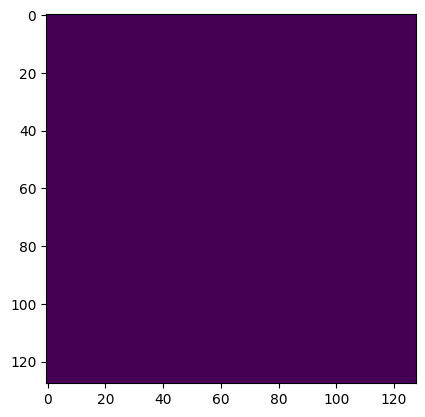

In [8]:
with h5py.File(path_single_mask) as hdf:

    ls = list(hdf.keys())

    print("ls", ls)

    data = np.array(hdf.get('mask'))

    print("input data shape:", data.shape)

    plt.imshow(data)

In [9]:

class DataGenerator(Sequence):
    def __init__(self, image_dir, mask_dir, batch_size=1, img_size=(128, 128), shuffle=True):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle

        # List all the image and mask file names
        self.image_files = sorted(os.listdir(image_dir))
        self.mask_files = sorted(os.listdir(mask_dir))

    def __len__(self):
        # Number of batches per epoch
        return int(np.floor(len(self.image_files) / self.batch_size))

    def on_epoch_end(self):
        # Shuffle data at the end of each epoch
        if self.shuffle:
            temp = list(zip(self.image_files, self.mask_files))
            np.random.shuffle(temp)
            self.image_files, self.mask_files = zip(*temp)

    def __getitem__(self, index):
        # Get the list of image and mask files for this batch
        batch_images = self.image_files[index * self.batch_size:(index + 1) * self.batch_size]
        batch_masks = self.mask_files[index * self.batch_size:(index + 1) * self.batch_size]

        # Load and preprocess the images and masks
        images = []
        masks = []
        for img_file, mask_file in zip(batch_images, batch_masks):
            img = self.load_image(os.path.join(self.image_dir, img_file))
            mask = self.load_mask(os.path.join(self.mask_dir, mask_file))
            images.append(img)
            masks.append(mask)

        return np.array(images), np.array(masks)

    def load_image(self, img_path):
        with h5py.File(img_path, 'r') as hdf:
            img_data = np.array(hdf.get('img'))  # (128, 128, 14)
            img_data = img_data / 255.0  # Normalize to [0, 1]
            return img_data

    def load_mask(self, mask_path):
        with h5py.File(mask_path, 'r') as hdf:
            mask_data = np.array(hdf.get('mask'))  # (128, 128)
            mask_data = np.expand_dims(mask_data, axis=-1)  # (128, 128, 1)
            return mask_data


In [10]:
""" Atrous Spatial Pyramid Pooling """
def ASPP(inputs):
    shape = inputs.shape

    y_pool = AveragePooling2D(pool_size=(shape[1], shape[2]), name='average_pooling')(inputs)
    y_pool = Conv2D(filters=256, kernel_size=1, padding='same', use_bias=False)(y_pool)
    y_pool = BatchNormalization(name=f'bn_1')(y_pool)
    y_pool = Activation('relu', name=f'relu_1')(y_pool)
    y_pool = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y_pool)

    y_1 = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(inputs)
    y_1 = BatchNormalization()(y_1)
    y_1 = Activation('relu')(y_1)

    y_6 = Conv2D(filters=256, kernel_size=3, dilation_rate=6, padding='same', use_bias=False)(inputs)
    y_6 = BatchNormalization()(y_6)
    y_6 = Activation('relu')(y_6)

    y_12 = Conv2D(filters=256, kernel_size=3, dilation_rate=12, padding='same', use_bias=False)(inputs)
    y_12 = BatchNormalization()(y_12)
    y_12 = Activation('relu')(y_12)

    y_18 = Conv2D(filters=256, kernel_size=3, dilation_rate=18, padding='same', use_bias=False)(inputs)
    y_18 = BatchNormalization()(y_18)
    y_18 = Activation('relu')(y_18)

    y = Concatenate()([y_pool, y_1, y_6, y_12, y_18])

    y = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    return y

In [11]:
def Detection_Model(shape):
    """ Inputs """
    inputs = Input(shape)

    """ Pre-trained ResNet50 """
    base_model = ResNet50(weights=None, include_top=False, input_tensor=inputs)

    """ Pre-trained ResNet50 Output """
    image_features = base_model.get_layer('conv4_block6_out').output
    x_a = ASPP(image_features)
    x_a = UpSampling2D((4, 4), interpolation="bilinear")(x_a)

    """ Get low-level features """
    x_b = base_model.get_layer('conv2_block2_out').output
    x_b = Conv2D(filters=48, kernel_size=1, padding='same', use_bias=False)(x_b)
    x_b = BatchNormalization()(x_b)
    x_b = Activation('relu')(x_b)

    x = Concatenate()([x_a, x_b])

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((4, 4), interpolation="bilinear")(x)

    """ Outputs """
    x = Conv2D(1, (1, 1), name='output_layer')(x)
    x = Activation('sigmoid')(x)

    """ Model """
    model = Model(inputs=inputs, outputs=x)
    return model

In [12]:

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = K.cast(y_true, dtype='float32')  # Ensure both are float32
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.flatten(y_true_f)  # Flatten after conversion

    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [13]:
train_generator = DataGenerator(
    image_dir='/kaggle/input/landslide4sense/TrainData/img',
    mask_dir='/kaggle/input/landslide4sense/TrainData/mask',
    batch_size=32,  # Adjust based on memory
    img_size=(128, 128),  # Match your input data
    shuffle=True
)

In [14]:
strategy = tf.distribute.MirroredStrategy()
input_shape = (128, 128, 14)
with strategy.scope():
    model = Detection_Model(input_shape)
    model.compile(optimizer=Adam(learning_rate=1e-4), 
                  loss=dice_loss, 
                  metrics=['accuracy'])
    model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 14)   │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 134, 134, 14)   │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │         43,968 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 32, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 32, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 32, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 17,864,705 (68.15 MB)

 Trainable params: 17,829,921 (68.02 MB)

 Non-trainable params: 34,784 (135.88 KB)

In [18]:
history = model.fit(train_generator, epochs=20)

Epoch 1/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 105s 831ms/step - accuracy: 0.9846 - loss: 0.3632
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 108s 860ms/step - accuracy: 0.9852 - loss: 0.3433
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 109s 862ms/step - accuracy: 0.9851 - loss: 0.3395
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 106s 844ms/step - accuracy: 0.9860 - loss: 0.3319
Epoch 5/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 105s 832ms/step - accuracy: 0.9860 - loss: 0.3314
Epoch 6/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 108s 852ms/step - accuracy: 0.9853 - loss: 0.3346
Epoch 7/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 112s 890ms/step - accuracy: 0.9860 - loss: 0.3042
Epoch 8/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 115s 914ms/step - accuracy: 0.9873 - loss: 0.3061
Epoch 9/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 112s 889ms/step - accuracy: 0.9868 - loss: 0.2979
Epoch 10/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 111s 883ms/step - accuracy: 0.9869 - loss: 0.3095
Epoch 11/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 108s 857ms/step - accuracy: 0.9863 - loss: 0.2975
Epoch 12

In [19]:
model.save("Landslide_Detection.h5")

In [21]:
import numpy as np
import pandas as pd
from tabulate import tabulate 

# Extract metrics from the history object
accuracy = history.history['accuracy']
loss = history.history['loss']
epochs = range(1, len(accuracy) + 1)

# Calculate dice coefficient from dice loss
dice_coef = [1 - loss_value for loss_value in loss]

# Create a DataFrame to store all metrics
metrics_df = pd.DataFrame({
    'Epoch': epochs,
    'Accuracy': accuracy,
    'Dice Loss': loss,
    'Dice Coefficient': dice_coef
})

# Add validation metrics if available
if 'val_accuracy' in history.history and 'val_loss' in history.history:
    val_accuracy = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    val_dice_coef = [1 - val_loss_value for val_loss_value in val_loss]
    
    metrics_df['Val Accuracy'] = val_accuracy
    metrics_df['Val Dice Loss'] = val_loss
    metrics_df['Val Dice Coefficient'] = val_dice_coef

# Format the DataFrame for better readability
formatted_df = metrics_df.copy()
for col in metrics_df.columns:
    if col != 'Epoch':
        formatted_df[col] = formatted_df[col].apply(lambda x: f"{x:.4f}")

# Print the metrics table
print("\n=== Training Metrics by Epoch ===\n")
print(tabulate(formatted_df, headers='keys', tablefmt='pretty', showindex=False))

# Save metrics to CSV
metrics_df.to_csv('training_metrics.csv', index=False)


=== Training Metrics by Epoch ===

+-------+----------+-----------+------------------+
| Epoch | Accuracy | Dice Loss | Dice Coefficient |
+-------+----------+-----------+------------------+
|   1   |  0.9846  |  0.3648   |      0.6352      |
|   2   |  0.9854  |  0.3481   |      0.6519      |
|   3   |  0.9856  |  0.3453   |      0.6547      |
|   4   |  0.9857  |  0.3259   |      0.6741      |
|   5   |  0.9852  |  0.3351   |      0.6649      |
|   6   |  0.9859  |  0.3298   |      0.6702      |
|   7   |  0.9860  |  0.3120   |      0.6880      |
|   8   |  0.9868  |  0.3124   |      0.6876      |
|   9   |  0.9867  |  0.3081   |      0.6919      |
|  10   |  0.9872  |  0.3077   |      0.6923      |
|  11   |  0.9872  |  0.3046   |      0.6954      |
|  12   |  0.9869  |  0.2951   |      0.7049      |
|  13   |  0.9875  |  0.3000   |      0.7000      |
|  14   |  0.9873  |  0.2901   |      0.7099      |
|  15   |  0.9876  |  0.2913   |      0.7087      |
|  16   |  0.9870  |  0.2916

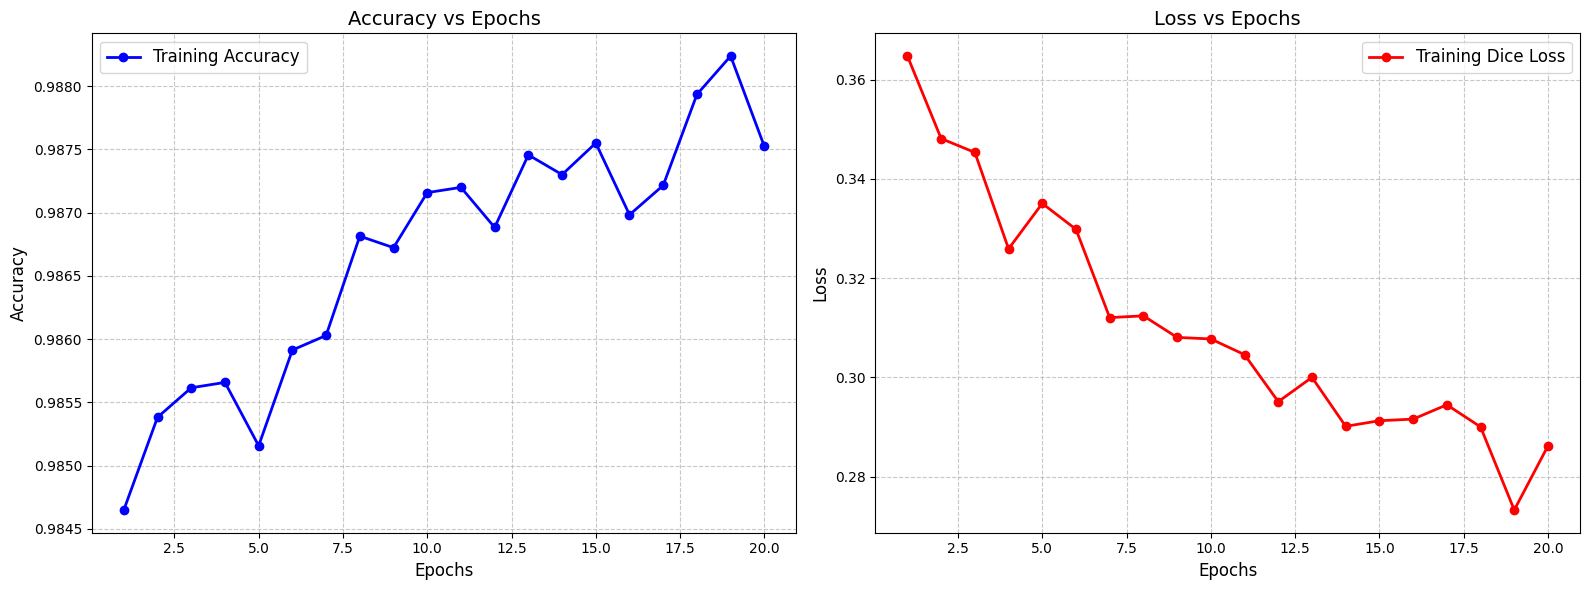

In [22]:
# Accuracy and Loss plots
plt.figure(figsize=(16, 6))

# Plot accuracy vs epochs
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Training Accuracy', marker='o', color='blue', linewidth=2)
if 'val_accuracy' in history.history:
    plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='s', color='skyblue', linewidth=2)
plt.title('Accuracy vs Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

# Plot loss vs epochs
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Dice Loss', marker='o', color='red', linewidth=2)
if 'val_loss' in history.history:
    plt.plot(epochs, val_loss, label='Validation Dice Loss', marker='s', color='salmon', linewidth=2)
plt.title('Loss vs Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

plt.tight_layout()
plt.savefig('accuracy_loss_plots.png', dpi=300, bbox_inches='tight')
plt.show()

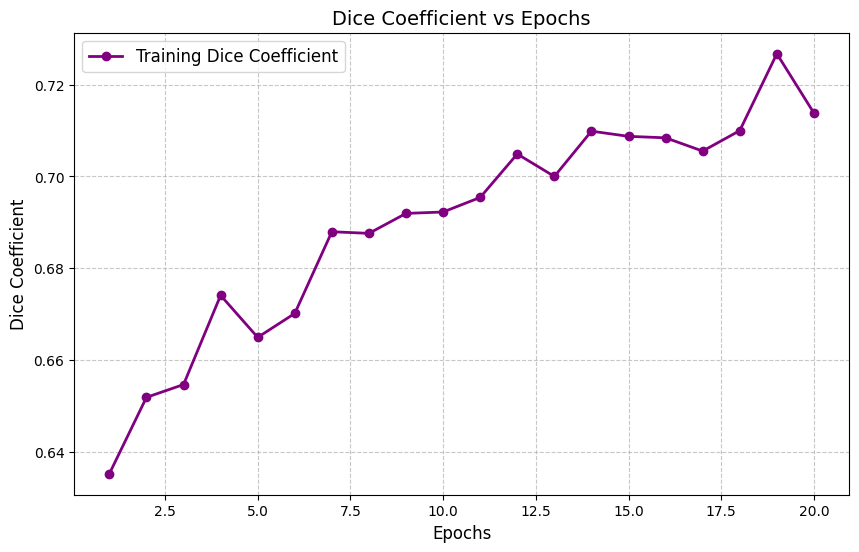

In [23]:
# Dice Coefficient plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, dice_coef, label='Training Dice Coefficient', marker='o', color='purple', linewidth=2)
if 'val_loss' in history.history:
    plt.plot(epochs, val_dice_coef, label='Validation Dice Coefficient', marker='s', color='orchid', linewidth=2)
plt.title('Dice Coefficient vs Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Dice Coefficient', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.savefig('dice_coefficient_plot.png', dpi=300, bbox_inches='tight')
plt.show()

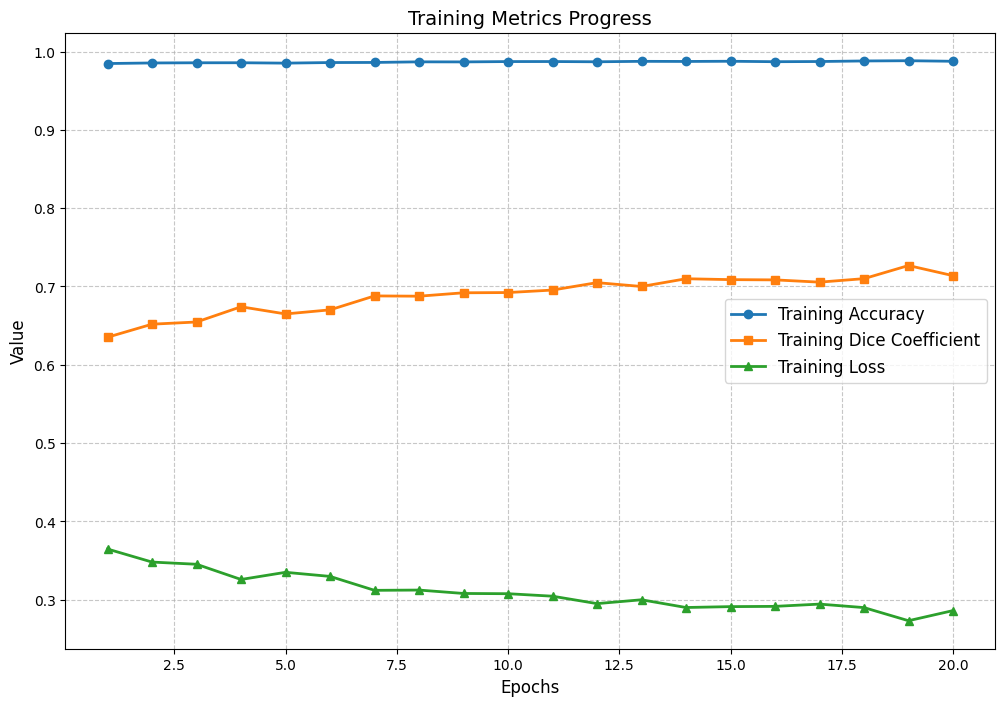

In [24]:
# Combined metrics plot
plt.figure(figsize=(12, 8))
plt.plot(epochs, accuracy, label='Training Accuracy', marker='o', linewidth=2)
plt.plot(epochs, dice_coef, label='Training Dice Coefficient', marker='s', linewidth=2)
plt.plot(epochs, loss, label='Training Loss', marker='^', linewidth=2)
if 'val_accuracy' in history.history:
    plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o', linestyle='--', linewidth=2)
    plt.plot(epochs, val_dice_coef, label='Validation Dice Coefficient', marker='s', linestyle='--', linewidth=2)
    plt.plot(epochs, val_loss, label='Validation Loss', marker='^', linestyle='--', linewidth=2)
plt.title('Training Metrics Progress', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.savefig('combined_metrics_plot.png', dpi=300, bbox_inches='tight')
plt.show()

In [25]:
# Generate summary statistics table
summary_stats = {
    'Metric': ['Accuracy', 'Dice Loss', 'Dice Coefficient'],
    'Min': [min(accuracy), min(loss), min(dice_coef)],
    'Max': [max(accuracy), max(loss), max(dice_coef)],
    'Mean': [np.mean(accuracy), np.mean(loss), np.mean(dice_coef)],
    'Final': [accuracy[-1], loss[-1], dice_coef[-1]]
}

if 'val_accuracy' in history.history:
    summary_stats['Metric'].extend(['Val Accuracy', 'Val Dice Loss', 'Val Dice Coefficient'])
    summary_stats['Min'].extend([min(val_accuracy), min(val_loss), min(val_dice_coef)])
    summary_stats['Max'].extend([max(val_accuracy), max(val_loss), max(val_dice_coef)])
    summary_stats['Mean'].extend([np.mean(val_accuracy), np.mean(val_loss), np.mean(val_dice_coef)])
    summary_stats['Final'].extend([val_accuracy[-1], val_loss[-1], val_dice_coef[-1]])

summary_df = pd.DataFrame(summary_stats)
for col in summary_df.columns:
    if col != 'Metric':
        summary_df[col] = summary_df[col].apply(lambda x: f"{x:.4f}")

print("\n=== Summary Statistics ===\n")
print(tabulate(summary_df, headers='keys', tablefmt='pretty', showindex=False))

# Save summary stats to CSV
pd.DataFrame(summary_stats).to_csv('summary_metrics.csv', index=False)


=== Summary Statistics ===

+------------------+--------+--------+--------+--------+
|      Metric      |  Min   |  Max   |  Mean  | Final  |
+------------------+--------+--------+--------+--------+
|     Accuracy     | 0.9846 | 0.9882 | 0.9867 | 0.9875 |
|    Dice Loss     | 0.2733 | 0.3648 | 0.3103 | 0.2862 |
| Dice Coefficient | 0.6352 | 0.7267 | 0.6897 | 0.7138 |
+------------------+--------+--------+--------+--------+


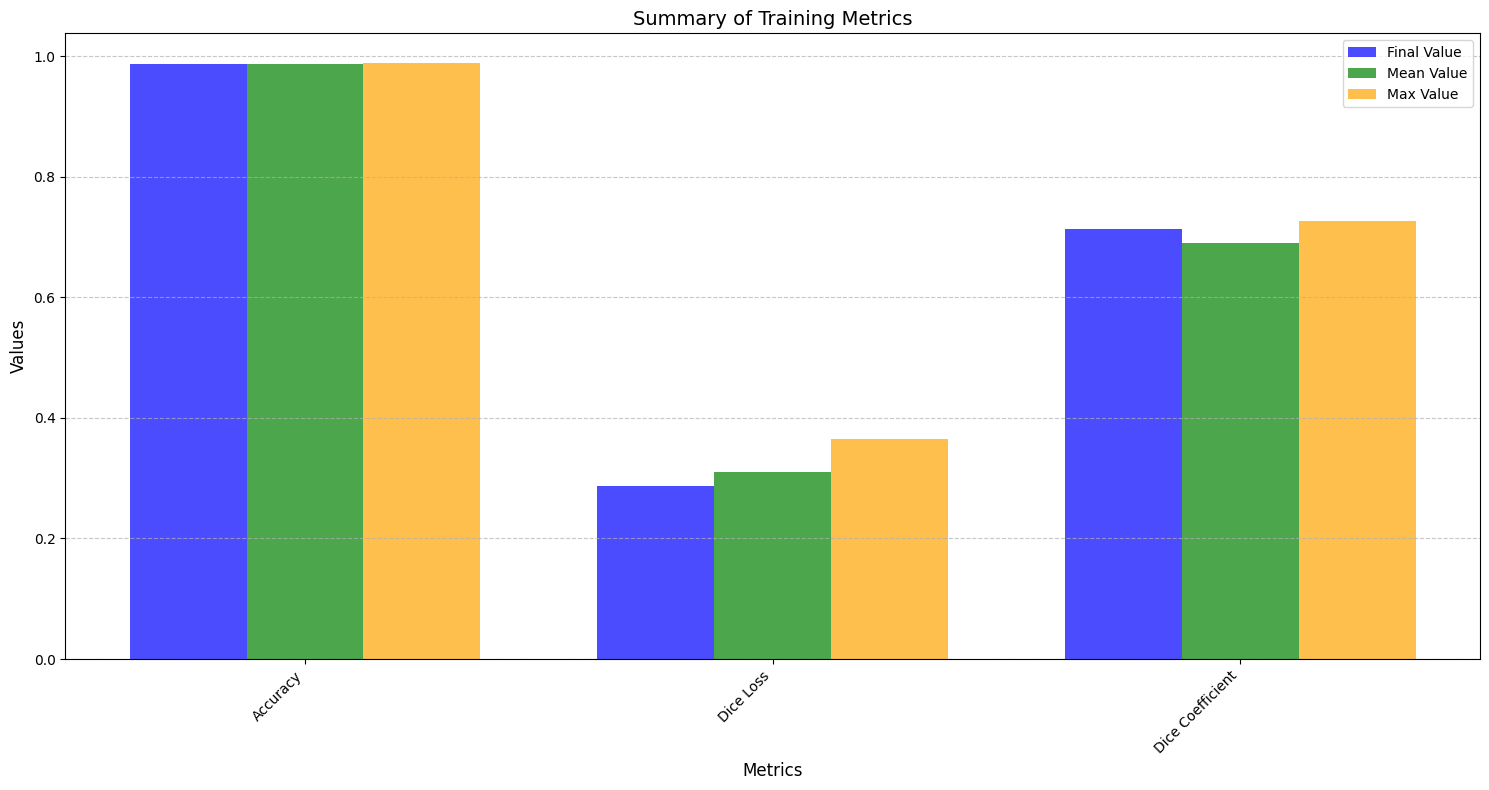

In [26]:
# Create a visualization of the summary statistics
plt.figure(figsize=(15, 8))

# Get metrics for plotting
metrics = summary_df['Metric'].tolist()
final_values = [float(x) for x in summary_df['Final'].tolist()]
mean_values = [float(x) for x in summary_df['Mean'].tolist()]
max_values = [float(x) for x in summary_df['Max'].tolist()]

# Set up bar positions
x = np.arange(len(metrics))
width = 0.25

# Create grouped bar chart
plt.bar(x - width, final_values, width, label='Final Value', color='blue', alpha=0.7)
plt.bar(x, mean_values, width, label='Mean Value', color='green', alpha=0.7)
plt.bar(x + width, max_values, width, label='Max Value', color='orange', alpha=0.7)

plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.title('Summary of Training Metrics', fontsize=14)
plt.xticks(x, metrics, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('metrics_summary_chart.png', dpi=300, bbox_inches='tight')
plt.show()